In [1]:
## compare SAX state representation

# expectation
# 1. 2 similar states of the same person should be similar
# 1. 2 similar states of 2 different persons sould be similar

import pandas as pd
import numpy as np
import os
import pickle
#import re
import regex as re
import matplotlib.pyplot as plt

In [15]:
## create SAX string representation & dimer features

# STEPS
# for each epoch:
# 1. normalize the data over a window (epoch size)
# 2. convert to PAA - take small segments & represent by the average over the segment
# 3. choose alphabet size & the levels/ threshold for discretisation
# 4. convert to string representation
# 5. vector representation - numbers of different dimers

# discretise over 0.25S = 0.25 * 100 = 25 points; reduces to 120 points
#               0.5s => 50 points; reduces to 60 points
#               0.1 s = 0.1 * 100 = 10 points -> 300 data points
#               0.05s = 5 points -> 600 data points


### 1. normalise the data, 1 epoch (30s, i.e. 3000 data points) at a time ###
# if the SD is very small (less than a threshold), do not normalize the data
def z_norm(y):
    sd = y.std()
    print('SD: ' + str(sd))
    if sd < 0.01:
        y = y
    else:
        y =(y - y.mean())/sd
    
    return y



#### 2. convert to PAA - take a window & represent by the average over the window ####
# discretise over 0.25S = 0.25 * 100 = 25 points  -> results in 120 data points
#               0.5s = 50 points   -> results in 60 data points
#               0.1 s = 0.1 * 100 = 10 points -> 300 data points
#               0.05s = 5 points -> 600 data points
#time_window = 0.5
def get_paa(y, time_window):
    # convert time_window from sec to no. of data points
    time_window = time_window * 100  # 100 is sampling freq
    
    paa = []
    for i in range(0, int(len(y)/time_window)): # len(y)/time_window gives the no. of steps
        # take a segment of data
        arr = y[(i * int(time_window)):((i+1) * int(time_window))]
        # convert to mean & append to list
        paa.append(arr.mean())
    return paa



#### 3. choose alphabet size & the levels/ threshold for discretisation ####
### set this up as a dictionary to choose different alphabet sizes  ###
# let alphabet size = 4;
# cuts: [-0.67, 0, 0.67]



#### 4. convert to string  ####
def get_sax_string(paa):
    sax = []
    
    for i in range(0,len(paa)):
        if paa[i] <= -0.67:
            alpha = 'a'
        elif (paa[i] > -0.67 and paa[i] <=0):
            alpha = 'b'
        elif (paa[i] > 0 and paa[i] <=0.67):
            alpha = 'c'
        else:
            alpha = 'd'
        sax.append(alpha)
    
    # convert sax from list to string format
    sax_string = ''.join(sax)
    return sax_string



#### 5. vector representation - numbers of different dimers ####
# different types of dimers
# aa ab ac ad
# ba bb bc bd
# ca cb cc cd
# da db dc dd
### ways to count ###
# sax_string.count(dim_alpha[i]) => 'bbb' : counts bb as 1  => FIX THIS
# len(re.findall(dim_alpha[i], sax_string)) : counts bb as 1

###  set up a list of the dimers possible  ###
dim_alpha = ['aa','ab','ac','ad','ba','bb','bc','bd','ca','cb','cc','cd','da','db','dc','dd']

def get_sax_dimer_array(sax_string):
    dim_arr = []
    
    for i in range(0, len(dim_alpha)):
        dim_arr.append(len(re.findall(dim_alpha[i], sax_string, overlapped=True)))
    #https://stackoverflow.com/questions/2970520/string-count-with-overlapping-occurrences
    
    #print(dim_arr)
    #ncols = 4
    #im = np.reshape(dim_arr,(-1,ncols)) #x.reshape(1754, 1754)
    #plt.gray()
    #plt.imshow(im)
    return dim_arr


time_window = 0.1
def run_all(y, time_window):
    y = z_norm(y)
    ## plot the normalized data 
    fig, ax = plt.subplots(figsize=(20,3))
    plt.plot(y, marker='o', markersize=2)
    plt.show()
    
    #time_window = 0.5
    paa = get_paa(y, time_window)
    ## plot the PAA data 
    fig, ax = plt.subplots(figsize=(20,3))
    plt.plot(paa, marker='o', markersize=2)
    plt.show()
    
    
    sax_string = get_sax_string(paa)
    print(sax_string)
    
    
    sax_feature = get_sax_dimer_array(sax_string)
    ## added the following 2 lines to make the data fraction
    total = sum(sax_feature)
    sax_feature = [x/total for x in sax_feature]
    #print(sax_feature)  #dim_arr)
    ncols = 4
    im = np.reshape(sax_feature,(-1,ncols)) #x.reshape(1754, 1754)
    plt.gray()
    plt.imshow(im)
    #return sax_feature

In [3]:
## open a file
file_location = 'C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\eeg_epochs_dec12_2018\\raw_data'
os.chdir(file_location) #'C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\eeg_epochs_dec12_2018')

dfull = pickle.load(open('Frac_sax_dimer_0.1s_EEG_all_patients.pkl', 'rb'))
dfull.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,pID,day,epoch,class_label
0,0.110368,0.050167,0.016722,0.013378,0.066890,0.173913,0.060201,0.020067,0.010033,0.083612,0.163880,0.046823,0.003344,0.010033,0.063545,0.107023,400,1,s1e1,wake
1,0.090301,0.040134,0.020067,0.016722,0.050167,0.210702,0.080268,0.010033,0.020067,0.096990,0.170569,0.030100,0.006689,0.003344,0.046823,0.107023,400,1,s1e2,wake
2,0.130435,0.043478,0.003344,0.000000,0.040134,0.210702,0.053512,0.023411,0.006689,0.070234,0.167224,0.030100,0.000000,0.003344,0.050167,0.167224,400,1,s1e3,wake
3,0.123746,0.083612,0.030100,0.006689,0.050167,0.073579,0.076923,0.033445,0.050167,0.050167,0.110368,0.066890,0.020067,0.023411,0.060201,0.140468,400,1,s1e4,wake
4,0.100334,0.073579,0.050167,0.000000,0.046823,0.060201,0.096990,0.033445,0.056856,0.076923,0.133779,0.080268,0.020067,0.026756,0.063545,0.080268,400,1,s1e5,wake


In [4]:
dfull[(dfull.pID == '400') & (dfull.epoch == 's1e3') & (dfull.class_label == 'wake') & (dfull.day == '1')]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,pID,day,epoch,class_label
2,0.130435,0.043478,0.003344,0.0,0.040134,0.210702,0.053512,0.023411,0.006689,0.070234,0.167224,0.0301,0.0,0.003344,0.050167,0.167224,400,1,s1e3,wake


In [5]:
dfull.dtypes

0              float64
1              float64
2              float64
3              float64
4              float64
5              float64
6              float64
7              float64
8              float64
9              float64
10             float64
11             float64
12             float64
13             float64
14             float64
15             float64
pID             object
day             object
epoch           object
class_label     object
dtype: object

In [6]:
dfull.groupby(['pID','class_label']).size()

pID  class_label  
400  sleep_stage_1     117
     sleep_stage_2     623
     wake             3882
401  sleep_stage_1     201
     sleep_stage_2    1222
     wake             3680
402  sleep_stage_1     278
     sleep_stage_2     947
     wake             3778
403  sleep_stage_1     106
     sleep_stage_2     885
     wake             3965
404  sleep_stage_1     303
     sleep_stage_2    1134
     wake             3307
405  sleep_stage_1     158
     sleep_stage_2     833
     wake             4038
406  sleep_stage_1     146
     sleep_stage_2     824
     wake             4076
407  sleep_stage_1     173
     sleep_stage_2     795
     wake             3862
408  sleep_stage_1     107
     sleep_stage_2     591
     wake             3709
409  sleep_stage_1     100
     sleep_stage_2    1073
     wake             2818
410  sleep_stage_1     182
     sleep_stage_2    1278
     wake             3679
411  sleep_stage_1      31
     sleep_stage_2     898
     wake             3943
412  slee

In [10]:
x = pickle.load(open('SC4001E0-PSG-EEG.pickle','rb'))
#list(x['wake'].keys())
print(x['wake'].keys())

dict_keys(['s1e1', 's1e2', 's1e3', 's1e4', 's1e5', 's1e6', 's1e7', 's1e8', 's1e9', 's1e10', 's1e11', 's1e12', 's1e13', 's1e14', 's1e15', 's1e16', 's1e17', 's1e18', 's1e19', 's1e20', 's1e21', 's1e22', 's1e23', 's1e24', 's1e25', 's1e26', 's1e27', 's1e28', 's1e29', 's1e30', 's1e31', 's1e32', 's1e33', 's1e34', 's1e35', 's1e36', 's1e37', 's1e38', 's1e39', 's1e40', 's1e41', 's1e42', 's1e43', 's1e44', 's1e45', 's1e46', 's1e47', 's1e48', 's1e49', 's1e50', 's1e51', 's1e52', 's1e53', 's1e54', 's1e55', 's1e56', 's1e57', 's1e58', 's1e59', 's1e60', 's1e61', 's1e62', 's1e63', 's1e64', 's1e65', 's1e66', 's1e67', 's1e68', 's1e69', 's1e70', 's1e71', 's1e72', 's1e73', 's1e74', 's1e75', 's1e76', 's1e77', 's1e78', 's1e79', 's1e80', 's1e81', 's1e82', 's1e83', 's1e84', 's1e85', 's1e86', 's1e87', 's1e88', 's1e89', 's1e90', 's1e91', 's1e92', 's1e93', 's1e94', 's1e95', 's1e96', 's1e97', 's1e98', 's1e99', 's1e100', 's1e101', 's1e102', 's1e103', 's1e104', 's1e105', 's1e106', 's1e107', 's1e108', 's1e109', 's1e110

In [11]:
x['sleep_stage_1'].keys()

dict_keys(['s1e1', 's1e2', 's1e3', 's1e4', 's2e1', 's3e1', 's4e1', 's4e2', 's4e3', 's4e4', 's4e5', 's4e6', 's5e1', 's5e2', 's5e3', 's5e4', 's6e1', 's7e1', 's8e1', 's9e1', 's10e1', 's11e1', 's11e2', 's12e1', 's12e2', 's12e3', 's12e4', 's13e1', 's14e1', 's15e1', 's16e1', 's16e2', 's16e3', 's16e4', 's17e1', 's17e2', 's17e3', 's18e1', 's18e2', 's18e3', 's18e4', 's19e1', 's20e1', 's20e2', 's21e1', 's21e2', 's21e3', 's21e4', 's21e5', 's22e1', 's22e2', 's22e3', 's23e1', 's24e1', 's24e2', 's24e3', 's24e4', 's24e5'])

In [12]:
x['sleep_stage_2'].keys()

dict_keys(['s1e1', 's1e2', 's1e3', 's1e4', 's1e5', 's1e6', 's1e7', 's1e8', 's1e9', 's1e10', 's1e11', 's1e12', 's1e13', 's2e1', 's3e1', 's3e2', 's4e1', 's4e2', 's4e3', 's4e4', 's4e5', 's4e6', 's4e7', 's5e1', 's5e2', 's6e1', 's6e2', 's6e3', 's6e4', 's6e5', 's7e1', 's8e1', 's9e1', 's10e1', 's10e2', 's11e1', 's11e2', 's11e3', 's11e4', 's11e5', 's12e1', 's12e2', 's12e3', 's12e4', 's12e5', 's12e6', 's12e7', 's12e8', 's13e1', 's13e2', 's13e3', 's14e1', 's14e2', 's14e3', 's14e4', 's14e5', 's14e6', 's14e7', 's14e8', 's14e9', 's14e10', 's14e11', 's14e12', 's14e13', 's14e14', 's14e15', 's14e16', 's14e17', 's14e18', 's14e19', 's14e20', 's14e21', 's14e22', 's14e23', 's14e24', 's14e25', 's14e26', 's14e27', 's14e28', 's14e29', 's14e30', 's14e31', 's15e1', 's16e1', 's16e2', 's16e3', 's16e4', 's16e5', 's17e1', 's17e2', 's18e1', 's18e2', 's18e3', 's18e4', 's18e5', 's18e6', 's18e7', 's19e1', 's19e2', 's20e1', 's20e2', 's20e3', 's20e4', 's20e5', 's20e6', 's21e1', 's22e1', 's22e2', 's22e3', 's22e4', 's22e5

In [8]:
x

{'wake': {'s1e1': array([ 5.01684982, -2.57875458,  1.35970696, ..., 41.58827839,
         28.08498168, 43.27619048]),
  's1e2': array([11.2996337 , 18.14505495, 18.8014652 , ..., 17.39487179,
          9.51794872, 13.36263736]),
  's1e3': array([13.36263736, 10.73699634,  6.32967033, ...,  2.95384615,
          3.89157509, -0.04688645]),
  's1e4': array([-1.92234432, -1.07838828, -2.76630037, ..., 10.54945055,
          3.32893773,  4.36043956]),
  's1e5': array([12.98754579, 16.17582418, 14.86300366, ..., 42.52600733,
         45.15164835, 31.55457875]),
  's1e6': array([ 80.97289377,  28.83516484,  29.58534799, ..., -27.8974359 ,
         -54.34139194, -51.24688645]),
  's1e7': array([-51.9032967 , -50.96556777, -51.71575092, ...,   2.01611722,
         -10.26813187,  -6.23589744]),
  's1e8': array([ -8.58021978, -12.51868132, -13.73772894, ...,   4.82930403,
           5.2981685 ,   3.23516484]),
  's1e9': array([  1.45347985,  -1.73479853,  -3.89157509, ...,  -3.98534799,
        

In [12]:
# select an epoch
k = list(x['wake'].keys())
y = x['wake'][k[0]]    # k[0] = 's1e1'

In [15]:
x['wake']['s1e1']

array([ 5.01684982, -2.57875458,  1.35970696, ..., 41.58827839,
       28.08498168, 43.27619048])

In [21]:
x['wake']['s1e1'].shape

(3000,)

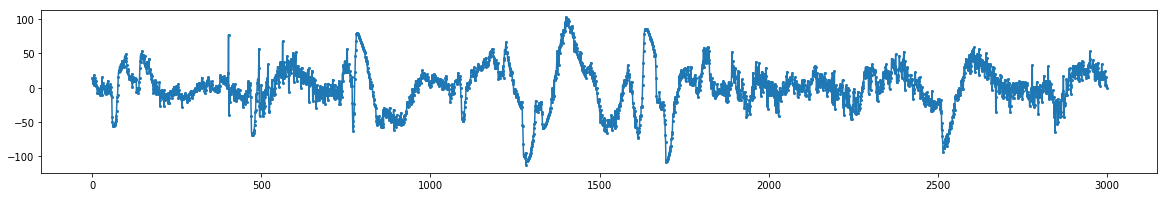

In [22]:
## plot the original data 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,3))
#plt.plot(x['wake'][k[0]], marker='o', markersize=2)
plt.plot(x['wake']['s1e3'], marker='o', markersize=2)
plt.show()

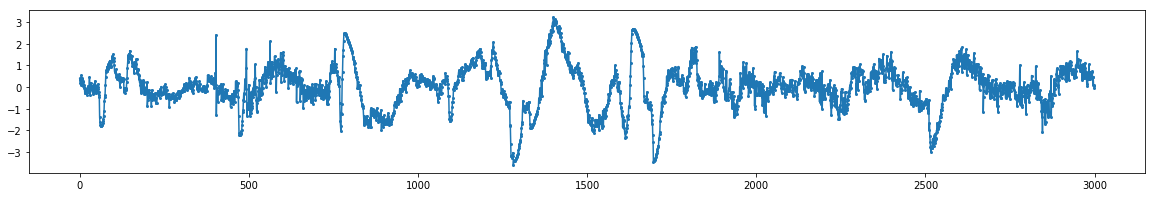

In [23]:
y = x['wake']['s1e3']
y = z_norm(y)

## plot the normalized data 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,3))
plt.plot(y, marker='o', markersize=2)
plt.show()

SD: 23.615496224654905


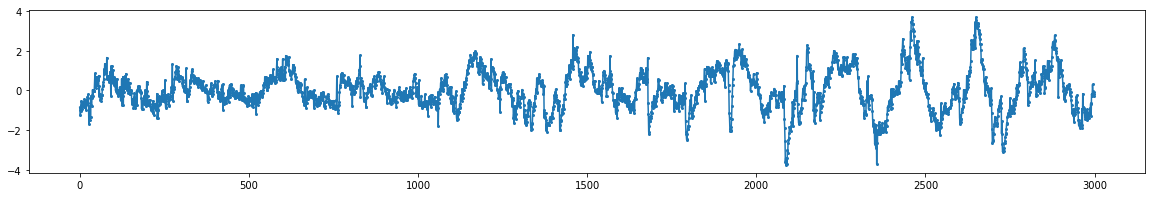

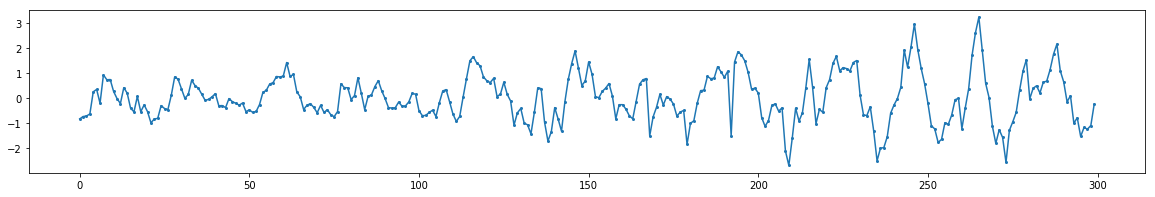

aaabccbdddcbbccbbcbbbaaabbbcddcbcdcccbbccbbbbbbbbbbbbbccccddddddccbbbbbbbbbabcccbcdcbcccdcbbbbbbbbccbaabbabccbbaacdddddddcdccccbabbaaabccaaabaabddddcdddccccccabbbaabcddaabcbcbbabbaaabccdddddddadddddcccaaabbbbaaababcdcabbcdddddddddcaabaaaaabbbcddddddcbaaaaaaabbabcddddccaaaaaaabcddbccccdddddcbcaaaaaab


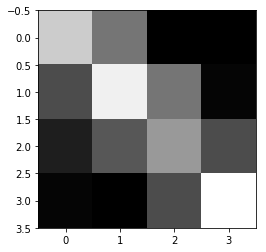

In [16]:
# case1:
y = x['wake']['s12e450']
run_all(y, time_window)

SD: 31.701060882839325


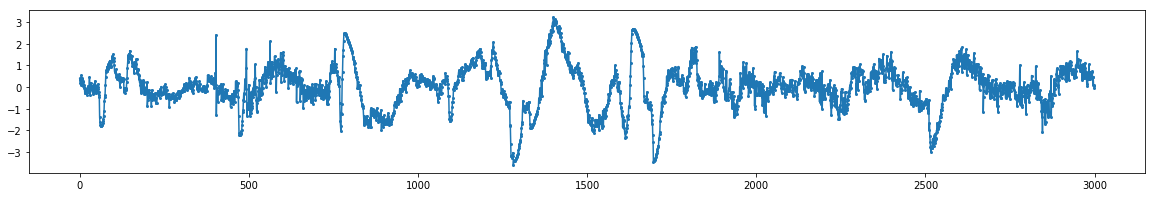

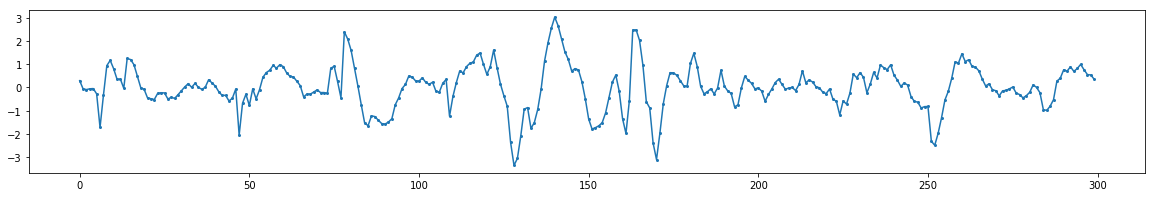

cbbbbbabdddccbdddcbbbbbbbbbbbbbcccccbccccbbbbbbaababbbccdddddcccccbbbbbbbbddcbddddcaaaaaaaaaaabbcccccccccbbccabcdcddddddcdddcbaaaaaaaaaabdddddddddddcbaaaaaabccbaabddddbaaaaacccccccdddcbbbbbdcbbaabcccbbbbbbcccbbbbcdccccbbbbbbababccccbcccddddcccccbbbaaaaaaabbcddddddddcccbbbbbbcbbbbbcbbaaabccdddddddccc


[0.13043478260869565,
 0.043478260869565216,
 0.0033444816053511705,
 0.0,
 0.04013377926421405,
 0.21070234113712374,
 0.05351170568561873,
 0.023411371237458192,
 0.006688963210702341,
 0.07023411371237458,
 0.16722408026755853,
 0.030100334448160536,
 0.0,
 0.0033444816053511705,
 0.05016722408026756,
 0.16722408026755853]

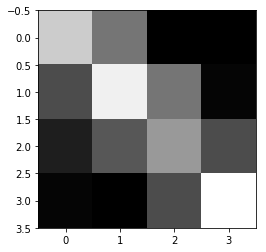

In [35]:
# case2:
y = x['wake']['s1e3']
run_all(y, time_window)

SD: 22.319755889910027


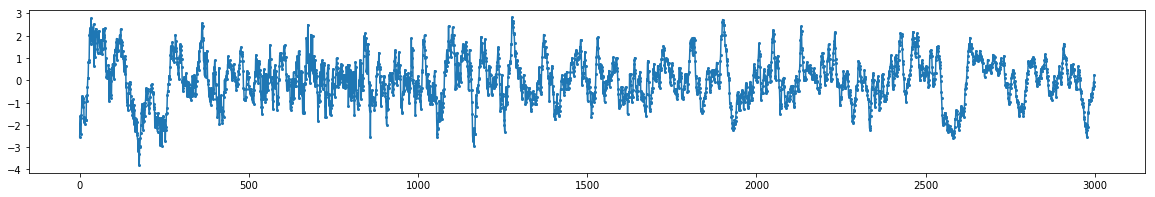

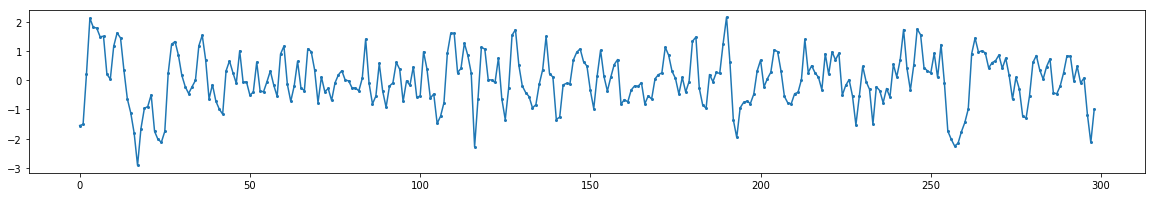

aacdddddccdddcbaaaaaabaaaacdddcbbbbdddbbaaacccbdbbbbcbbbcbbddbabcbbddcacbbabcccbbbbcdbabcbabbccabbcbbdcbbaaadddccddcabddccbdbabddcbbbaabcdccaabbbdddccbacdcbccdababbbbabbcccddccbcbbddbaacbccddcaaaaaabcdbccddcbaabbcdccccbdcdddbbcbabcbbabbabbccddcbcddcccdcdbaaaaaaadddddccddcdcbcbaabcdcccdbbbcddbcbcaaa


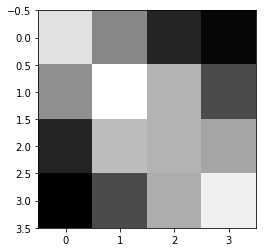

In [17]:
# case1:
y = x['sleep_stage_1']['s3e1']
run_all(y, time_window)

SD: 13.363639032225054


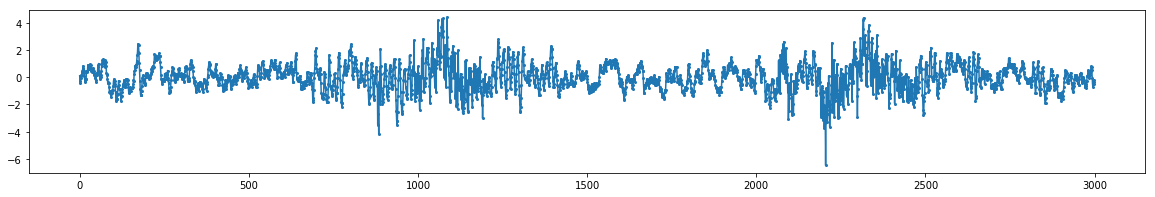

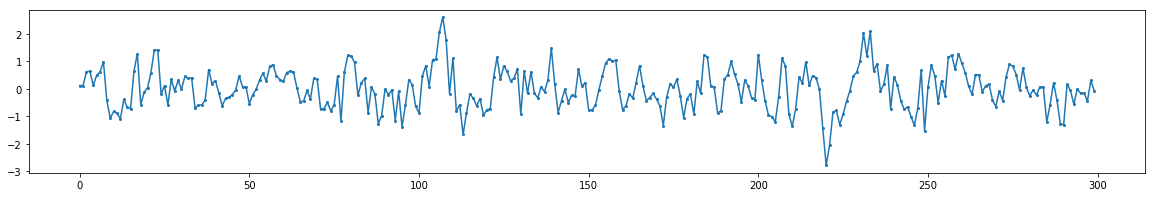

cccccccdbaaaabaacdbbccddbcbcbcbcccabbbdccbbbbbbcccbbbcccddcccccccbbbbccaababcacdddbccacbaabbbababccbacdcdddddbdabaabbbbaaacdcdcccdacbcbbcbcdcabbbbbdccaabbcddddbabbbcdcbbbbbabcccbabbacbddccaaccdccbccbbdcbaaabddaaaccdcccbaaaaaaabbccddddcdbcdaccbabaaadacdcbcbdddddccbccbccbbbbcddcbdcbbbccabcbaacbbbbbbcb


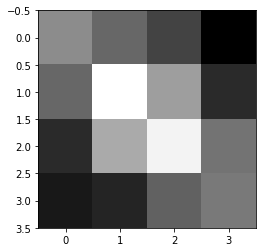

In [19]:
# case1:
y = x['sleep_stage_1']['s4e1']
run_all(y, time_window)

SD: 8.689852506924673


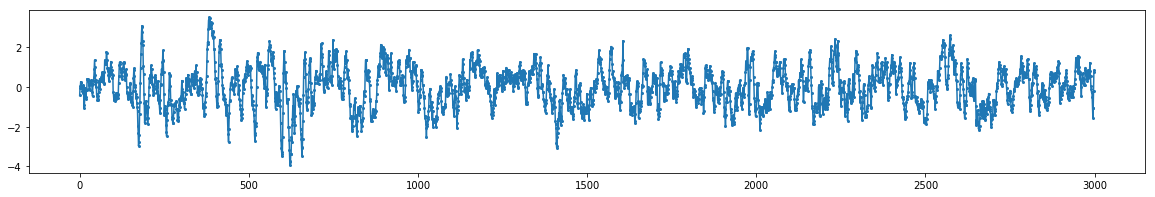

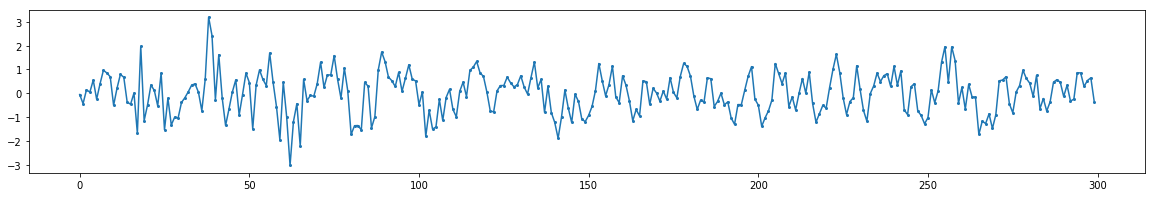

bbcccbcdddbcddbbcadabccbdabaaabbccccacddbdbabccabdcacdccdcbacaaabacbbbcdcdddcbdcaaaaccaaddddccdccdccbcaaaababcaaccbdddddcaacccdcccdcbcdccacaaaacbabbaaabcdcbcdbbdcbaaaccbccbcbccbddddbabbccbbcbbaabbcddbbaaabddcdbbabccdbaabbcdddbabbdcaabcdcddcdcdaaccaaaacbcddcddbcbcbbaaaaaaccdbaccdccbdbbabcccbcbbddcccb


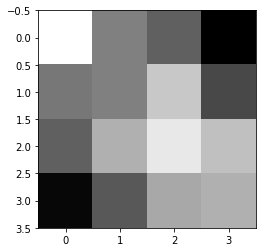

In [18]:
# case1:
y = x['sleep_stage_1']['s21e3']
run_all(y, time_window)

SD: 22.437552844646564


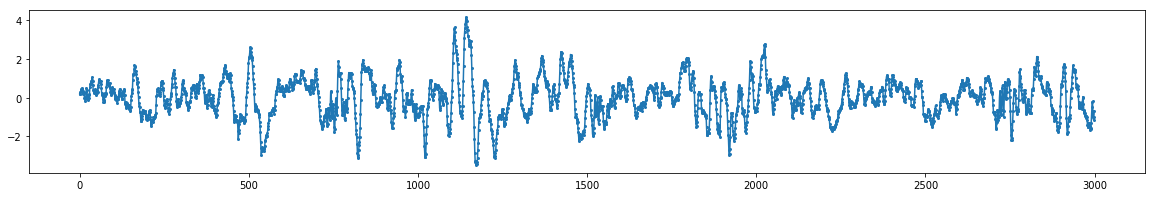

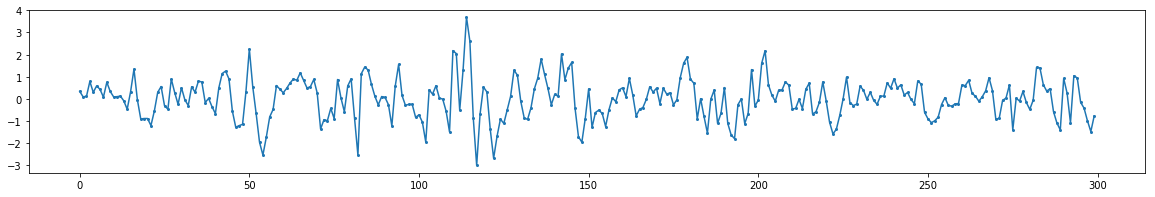

cccdccccdccccbbcdbaaaabccbbdcbcbbccddbcbacdddbaaacdcbaaaabccccdddddccdcaaabadcbcdaadddccbccbacdcbbbaaaaccccbbaddbdddaaaccaaaaabcddbaabcdddcbccddddbaaacabbbabcbcccdcabbbcccbcccbbdddddacaabcabcaaabbabdbbddccbccdcbbbbcdabbdbaaaacdbbbccbcbbccdcdccccbbdcbaaaabcbbbbccdccbccdcaabccacbcbbbddcccbaadcaddbbaaa


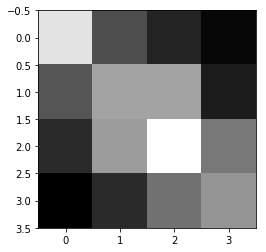

In [20]:
# case1:
y = x['sleep_stage_2']['s4e4']
run_all(y, time_window)

SD: 20.746256498452713


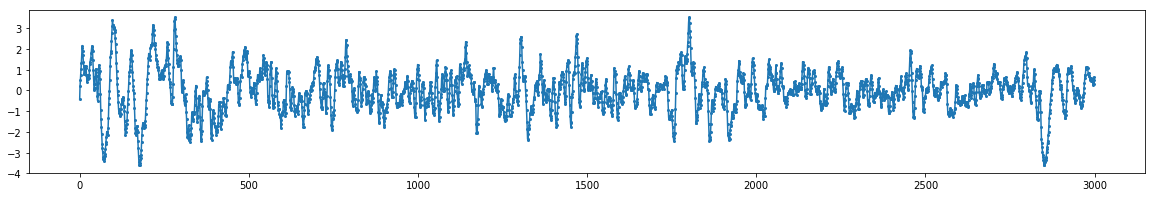

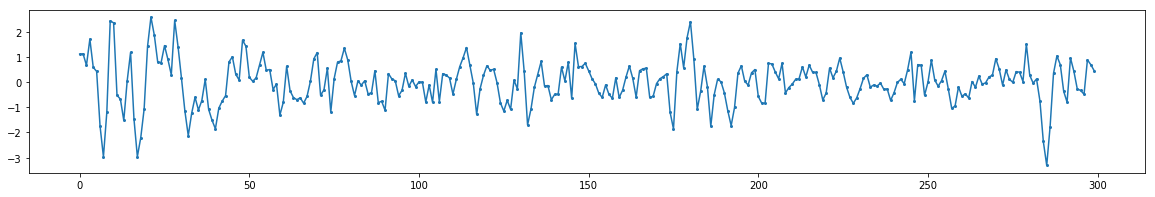

ddddccaaaddbbacdaaaadddddddcddcaaabaacaaaaabddccddcccddccbbaacbbababcddbbcacddddcbcbcbbcaaacccbbcbcbccabacacccbccdddbabccccbaaaacbdcaabcdbbabbccdbdccdccbbbbbbcbbcccbcccbbbcccaacdcdddabcbabccbaaacccbccbaaddccdbbbccccdccbabcccdcbbabbccbbbbbbabbcbcdaddbcdcbccbaabbbbcbcbbccdcbccccccdcbcaaaacddbadcbbbddc


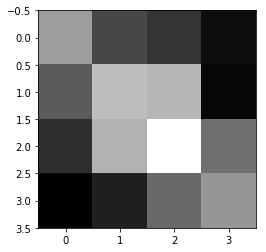

In [21]:
# case1:
y = x['sleep_stage_2']['s4e5']
run_all(y, time_window)

SD: 14.936726485488672


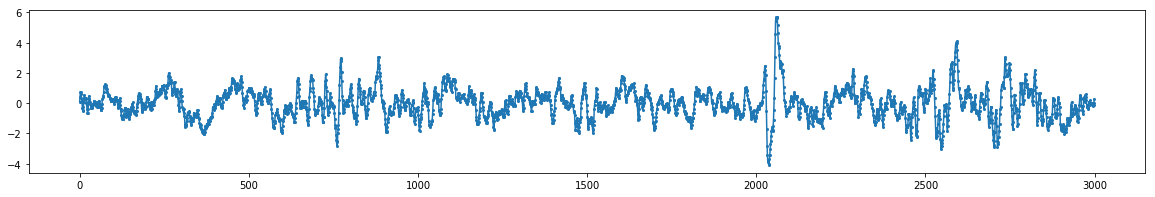

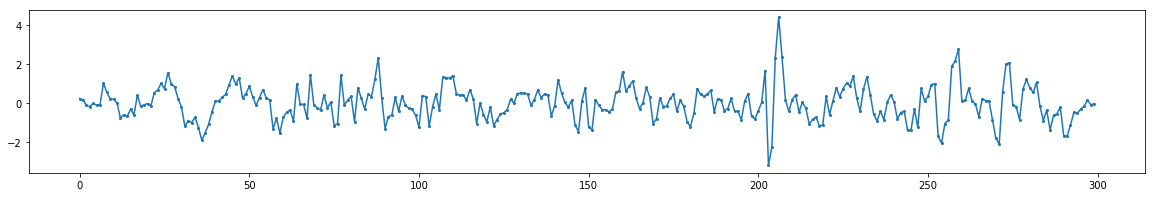

ccbbbbbdccccababbcbbbbcddddddcbaaaaaaaabccccddddccdcbcdccaaaabbadbbadbbbcbcaadbccadcbccddcaabcbcbbbbaccabcbddddccccdcacbabaabbbccccccbcdcccbbdccbcaacdaacbbbbbccdcddcbcdcaacbbccbcbaabdccccbccbbcbbaccbabcdaadddcbccbcbaaaaacbcdcddddcbddcbabacccabbaabadccddaaaadddccdcbacccaaacddbbadddcdbababbbaaabbbbcbb


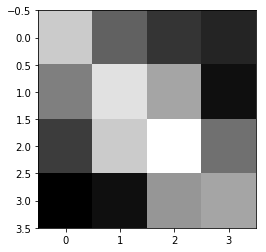

In [22]:
# case1:
y = x['sleep_stage_2']['s40e3']
run_all(y, time_window)

In [23]:
x1 = pickle.load(open('SC4021E0-PSG-EEG.pickle','rb'))
print('x1, wake')
print(x1['wake'].keys())
print('')
print('x1, sleep_stage_1')
print(x1['sleep_stage_1'].keys())
print('')
print('x1, sleep_stage_2')
print(x1['sleep_stage_2'].keys())

x1, wake
dict_keys(['s1e1', 's1e2', 's1e3', 's1e4', 's1e5', 's1e6', 's1e7', 's1e8', 's1e9', 's1e10', 's1e11', 's1e12', 's1e13', 's1e14', 's1e15', 's1e16', 's1e17', 's1e18', 's1e19', 's1e20', 's1e21', 's1e22', 's1e23', 's1e24', 's1e25', 's1e26', 's1e27', 's1e28', 's1e29', 's1e30', 's1e31', 's1e32', 's1e33', 's1e34', 's1e35', 's1e36', 's1e37', 's1e38', 's1e39', 's1e40', 's1e41', 's1e42', 's1e43', 's1e44', 's1e45', 's1e46', 's1e47', 's1e48', 's1e49', 's1e50', 's1e51', 's1e52', 's1e53', 's1e54', 's1e55', 's1e56', 's1e57', 's1e58', 's1e59', 's1e60', 's1e61', 's1e62', 's1e63', 's1e64', 's1e65', 's1e66', 's1e67', 's1e68', 's1e69', 's1e70', 's1e71', 's1e72', 's1e73', 's1e74', 's1e75', 's1e76', 's1e77', 's1e78', 's1e79', 's1e80', 's1e81', 's1e82', 's1e83', 's1e84', 's1e85', 's1e86', 's1e87', 's1e88', 's1e89', 's1e90', 's1e91', 's1e92', 's1e93', 's1e94', 's1e95', 's1e96', 's1e97', 's1e98', 's1e99', 's1e100', 's1e101', 's1e102', 's1e103', 's1e104', 's1e105', 's1e106', 's1e107', 's1e108', 's1e109'

SD: 11.136995344171366


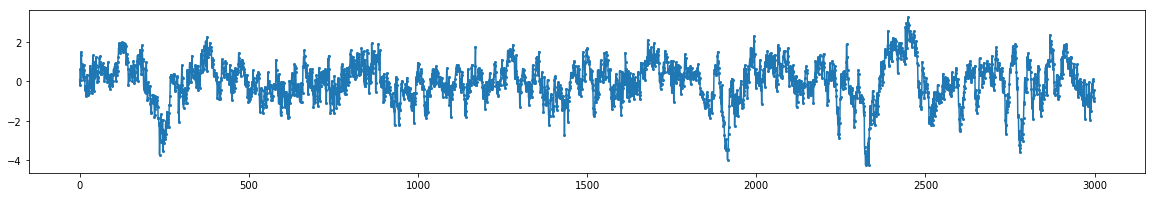

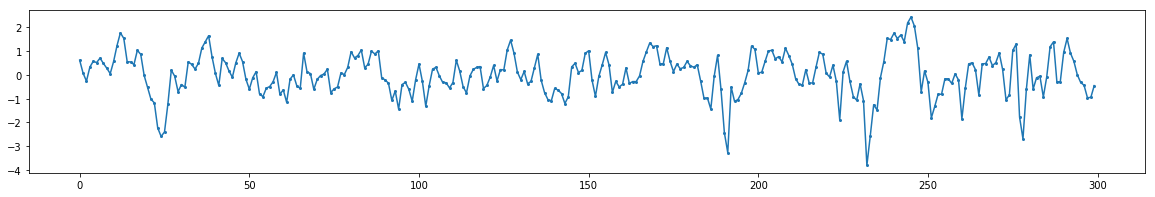

ccbcccdccccdddcccddbbaaaaaacbabbccccddddcbdccbcdcbbbcaabbbcababbbbdccbbbccabbcccddddccdddbbbaaabbbabcbabccbbbbbccbabcccbbbcbccdddcbcbbcdbaaabbaaaccccddbabcdcabbbcbbbbcddddccdcccccccccbaaabdbaabaaabcddcccddddcddcbbbcbbcddcbcbaccbaabaaaaabcddddddddddacbaaaabbbcbabcccaccdccdcaaddaabdbbbabddbbdddccbbaab


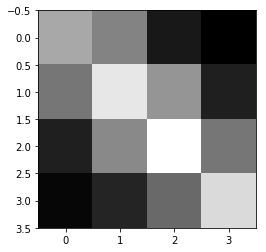

In [24]:
# case2:
y = x1['wake']['s1e3']
run_all(y, time_window)

In [25]:
y.dtype

dtype('float64')

In [26]:
y

array([  0.96923077,  -1.89230769,   7.06153846, ..., -10.93846154,
        -8.90769231,  -4.75384615])

SD: 22.40279069207449


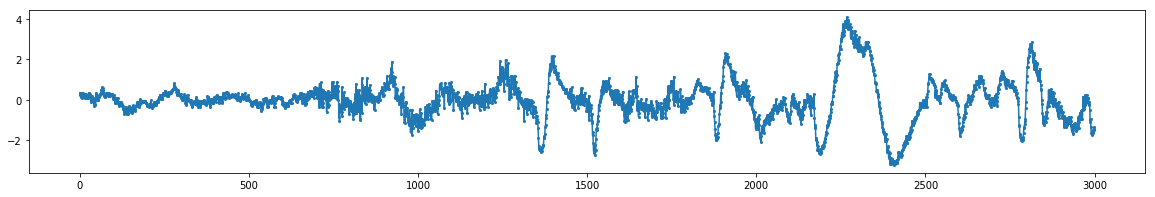

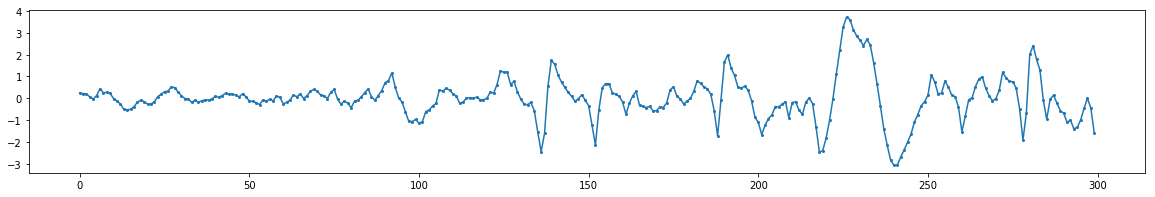

ccccbcccccbbbbbbbbbbbbbccccccccbbbbbbbbbccccccccccbbbbbbbbccbbbcccbccccccbccbbbbbbbccccbccdddccbbaaaaabbbbccccccbbccccbbbcccdddcdcbbbbbaaacddddcccbbcbbaabcdccccbabccbbbbbbbbbcccbbbbcddcccbabddddccccbaaaaaabbbbabbbabcbaaaaabddddddddddddcbaaaaaaaaaaabbcddccdcccbaabccddccbbcddddcbabddddbabcbbaaaaaabcba


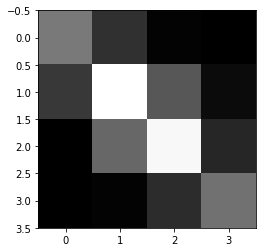

In [27]:
y = x1['wake']['s9e1']
run_all(y, time_window)

SD: 15.97866164089845


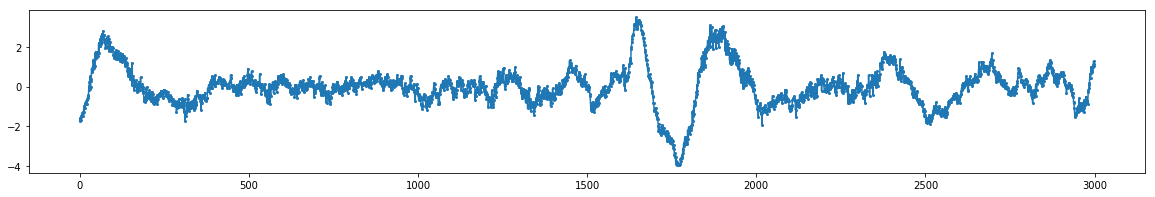

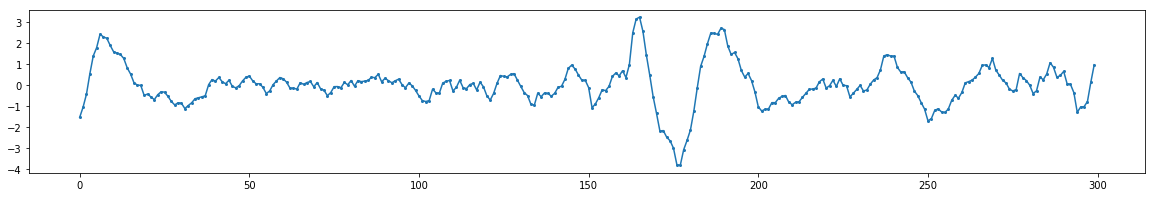

aabcdddddddddddccbbbbbabbbbaaaaaaabbbbcccccccbbbccccccbbbcccccbbbccccbcbbbbbbbcccbccccccccccccccbcbbbaaabbbcccbbcbbccbcbbabcccccccbbbaabbbbbbbbcdddcccbaabbbbcccdcddddddcbaaaaaaaaaaaabdddddddddddddcccbaaaaaabbbaaaabbbbbccbbcbcbbbbbbbbcccddddddccccbbaaaaaaaaaabbbcccccdddddcccbbbcccbbbcccddcccccbaaaacd


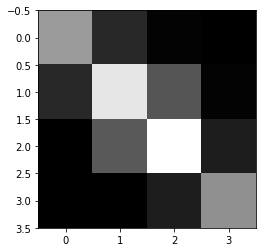

In [28]:
y = x1['sleep_stage_1']['s1e3']
run_all(y, time_window)

SD: 6.1590669760623085


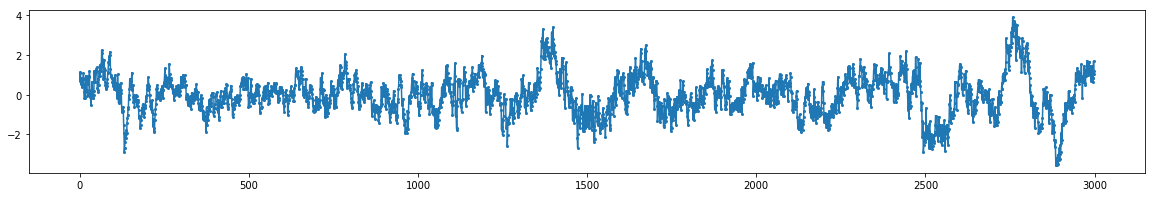

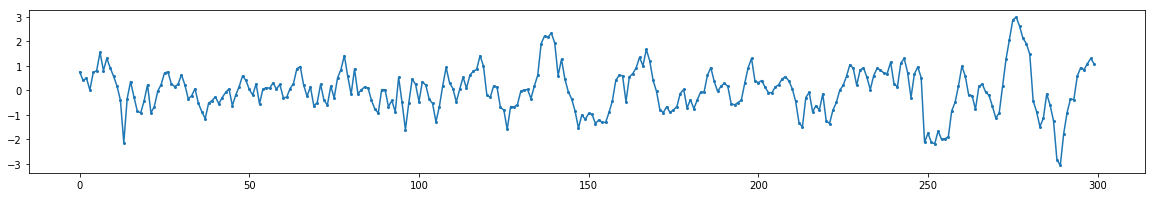

dcccddddddccbabcbaabcabbcddcccccbbcbaabbbbbbcbbccccbcbccccccbbccddcbcbbcbbcbcddcbdbcccbaaccabacbabccbccbbabcdccbccccddddbbccaaababbccbccdddddcdcbbaaaaaaaaaaabcccbcddddddcbaabaabbcababbbcdcbcccbbbbcddccccbbccccccbaabbababaaabcccddcddcccdddddccdddbcdcaaaaaaaaabcdcbbaccbbbaacddddddddbaaabbaaaaabbcddddd


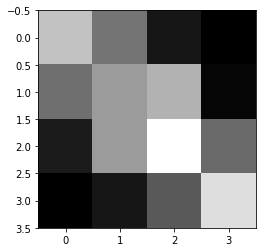

In [29]:
y = x1['sleep_stage_1']['s2e8']
run_all(y, time_window)

SD: 11.625983975754355


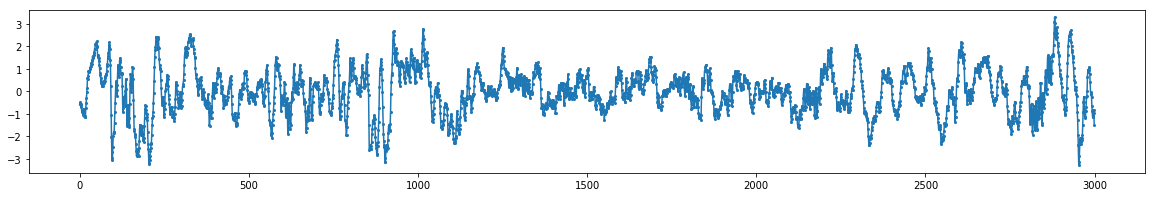

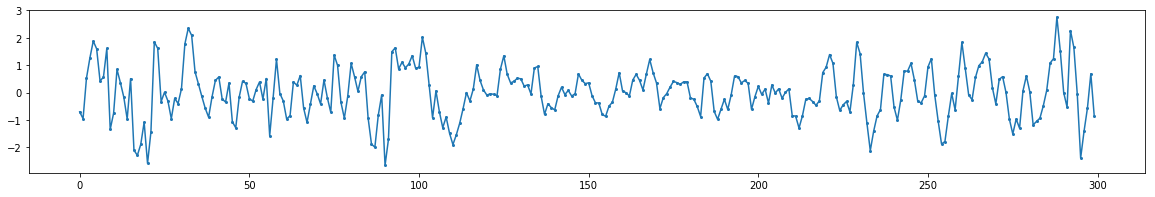

aacdddccdaadcbacaaaaaaddbcbabbcddddcbbabccbbcaabccbbccbcabdbbaacccbabcbbcbaddbabdcccdaaaabaadddddddddddcacaaaaaaabbbcdccbbbbddcccccccbddbabbbbcbcbbdcccbbbaabbcdcbbcccccddcbbbccccccbbbacdcaabbbbcccccbbcbcbcbcbccaaaabbbbbddddbbbbacddbaaaabcccbabdddcbbbddbaaaabbcddbbcddddcbcccaaaacccaaabcddddcbddbaabda


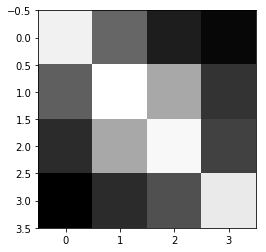

In [30]:
y = x1['sleep_stage_2']['s2e8']
run_all(y, time_window)

SD: 12.929849697630427


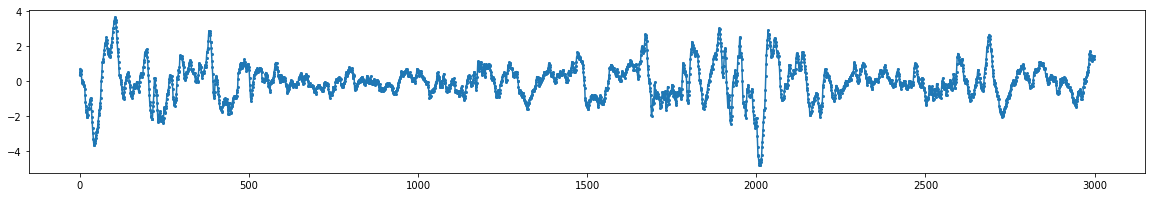

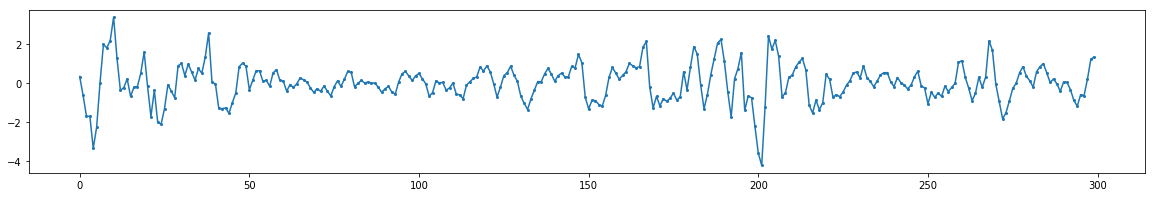

cbaaaacdddddbbcabbcdbabaaabbaddcdccdcddcbaaaaabdddbcccccbcdccbbbbcccbbbbbbbbcbcccbbccccbbbbbbbccccccccbabcbcbbbbbabcccdcdcbabccdccbaaabcccdccccccddddaaaaaabcdccccddddddbaaaaaabaacbdddbabcddddbacddabaaaaaddddabccddddaaaaaccababbccccdccbcccccbccbbbccbbabababbbbddcbabcbcddbaaaabbcdccbcddcccbbccbaabbcdd


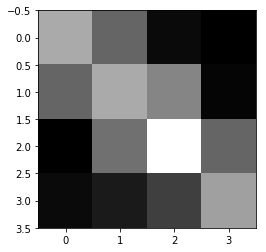

In [32]:
y = x1['sleep_stage_2']['s8e1']
run_all(y, time_window)